<a href="https://colab.research.google.com/github/DavidTorresP5/personalProjects/blob/master/Idoven_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idoven

In [1]:
import os
import glob
import sys
import tarfile
import pprint
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics

%matplotlib inline
np.random.seed(1)

## Download & preprocess data

In [2]:
!rm -rf ./*
"""
! wget -O PhysioNetChallenge2020_Training_CPSC.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/

! wget -O PhysioNetChallenge2020_Training_2.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_2.tar.gz/
! wget -O PhysioNetChallenge2020_Training_StPetersburg.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_StPetersburg.tar.gz/
! wget -O PhysioNetChallenge2020_Training_PTB.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_PTB.tar.gz/
"""
! wget -O PhysioNetChallenge2020_PTB-XL.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_PTB-XL.tar.gz/
! wget -O PhysioNetChallenge2020_Training_E.tar.gz \
https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_E.tar.gz/


--2020-06-20 15:54:11--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_PTB-XL.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 1448248661 (1.3G) [application/octet-stream]
Saving to: ‘PhysioNetChallenge2020_PTB-XL.tar.gz’

PhysioNetChallenge2 100%[===================>]   1.35G  33.1MB/s    in 41s     

2020-06-20 15:54:52 (33.7 MB/s) - ‘PhysioNetChallenge2020_PTB-XL.tar.gz’ saved [1448248661/1448248661]

--2020-06-20 15:54:53--  https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_E.tar.gz/
Resolving cloudypipeline.com (cloudypipeline.com)... 34.74.104.185
Connecting to cloudypipeline.com (cloudypipeline.com)|34.74.104.185|:9555... connected.
HTTP request sent, awaiting response... 200 
Length: 502442681 (479M) [application/octet-str

In [3]:
def extract_tar(tar_file):
    """
    
    """
    tarf = tarfile.open(tar_file)
    tarf.extractall()
    tarf.close()  

[extract_tar(tar_file) for tar_file in glob.glob('*.tar.gz')]

!rm *tar.gz
!ls

WFDB


In [4]:
df_y_code = pd.read_csv("https://raw.githubusercontent.com/physionetchallenges/physionetchallenges.github.io/master/2020/Dx_map.csv")
arr_y_code = np.array(df_y_code.iloc[:,1])
arr_y_code[:10]

array([270492004, 195042002, 164951009,  61277005, 426664006, 413444003,
       426434006,  54329005, 164889003, 195080001])

In [5]:
def get_files(input_directory):
    """
    
    """
    input_files = []

    for f in os.listdir(input_directory):
        if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
            input_files.append(os.path.join(input_directory,f))

    return input_files

def create_y_arr(header_data):
    """
    
    """
    y = np.array(header_data[15].replace("#Dx: ","").replace("\n","").split(","), dtype=int)

    Y = np.array(np.isin(arr_y_code, y), dtype=int)
    
    return Y


def load_x_data_flatten(filename):
    """
    
    """
    data = loadmat(filename)
    X = np.asarray(data['val'], dtype=int).flatten()
    if X.shape[0] > 60000:
      X = X[:60000]
    else:
      X = np.pad(X, pad_width=(0,60000-X.shape[0]))
    return X

def load_x_data(filename):
    """
    
    """
    data = loadmat(filename)
    X = np.transpose(np.asarray(data['val'], dtype=np.float32))
    return (X - np.min(X))/np.ptp(X)

def load_y_data(filename):
    """
    
    """
    with open(os.path.join(filename.replace('.mat', '.hea')), 'r') as f:
        header_data = f.readlines()
    Y = create_y_arr(header_data)
    return Y


In [6]:
files = get_files(input_directory = 'WFDB')
print(f"Number of files: {len(files)}")

#files = random.sample(files, 5000)
print(f"Number of sample files: {len(files)}")
print(f"Some filenames: {files[:5]}")

Number of files: 32181
Number of sample files: 32181
Some filenames: ['WFDB/HR07811.mat', 'WFDB/E08179.mat', 'WFDB/HR02452.mat', 'WFDB/HR16353.mat', 'WFDB/HR09280.mat']


In [7]:
X = [load_x_data(file) for file in files[:20000]]
X = np.array([np.pad(x, pad_width=[(0,5000-x.shape[0]), (0, 0)]) if x.shape[0] != 5000 else x for x in X ])
#X = np.array( [x for x in X if x.shape == (5000,12)])

In [8]:
Y = np.vstack([load_y_data(file) for file in files[:20000]])
print(f"X dims: {X.shape}")
print(f"Y dims: {Y.shape}")

X dims: (20000, 5000, 12)
Y dims: (20000, 107)


In [9]:
freq_y = np.sum(Y, axis = 0)
df_y_code['freq'] = freq_y
df_y_code.sort_values(by='freq', ascending=False).head(5)

,dx,SNOMED code,Abbreviation,freq
82,sinus rhythm,426783006,SNR,12425
46,left axis deviation,39732003,LAD,3843
57,myocardial infarction,164865005,MI,3323
90,t wave abnormal,164934002,TAb,2866
49,left ventricular hypertrophy,164873001,LVH,2258


['sinus rhythm']


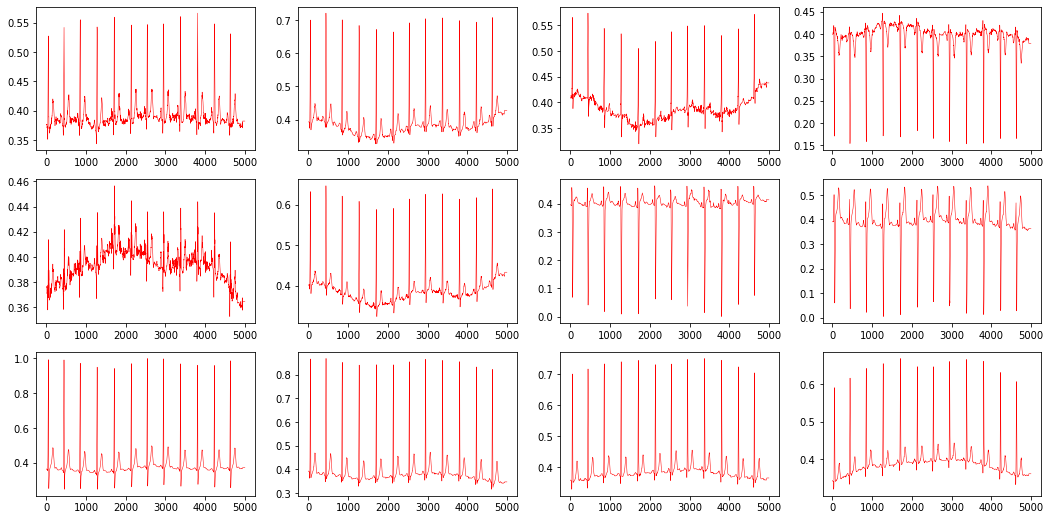

In [10]:
patient_number = 501
pprint.pprint(df_y_code["dx"][np.array(Y[patient_number],dtype=bool)].tolist())

fig = plt.figure(figsize=(18, 9))
for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.plot(X[patient_number,:,i],color= 'red', linewidth=0.5)
plt.show()


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, random_state=1)

print(f"Train:\nX:{X_train.shape} | Y:{Y_train.shape}")
print(f"Test:\nX:{X_test.shape} | Y:{Y_test.shape}")

Train:
X:(19000, 5000, 12) | Y:(19000, 107)
Test:
X:(1000, 5000, 12) | Y:(1000, 107)


In [12]:
import gc

del X, Y
gc.collect()

196

In [13]:
gc.collect()

0

## TensorFlow Model


In [24]:
model = models.Sequential()

# Block 0
model.add(layers.Conv1D(25, 5, input_shape=(5000, 12), name='conv0'))
model.add(layers.BatchNormalization(axis=2, name='bn0'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(3,name='max_pool0'))

# Block 1
model.add(layers.Conv1D(25, 5, name='conv1'))
model.add(layers.BatchNormalization(axis=2, name='bn1'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(3,name='max_pool1'))

# Block 2
model.add(layers.Conv1D(25, 5, name='conv2'))
model.add(layers.BatchNormalization(axis=2, name='bn2'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(3,name='max_pool2'))

# Block 3
model.add(layers.Conv1D(15, 3, name='conv3'))
model.add(layers.BatchNormalization(axis=2, name='bn3'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(3,name='max_pool3'))

# Block 4
model.add(layers.Conv1D(15, 3, name='conv4'))
model.add(layers.BatchNormalization(axis=2, name='bn4'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(2,name='max_pool4'))

# Block 5
model.add(layers.Conv1D(15, 3, name='conv5'))
model.add(layers.BatchNormalization(axis=2, name='bn5'))
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling1D(2,name='max_pool5'))
""""""

# Flatten & softmax
model.add(layers.Flatten())

model.add(layers.Dense(107, activation='softmax', name='fc'))



In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv1D)               (None, 4996, 25)          1525      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 4996, 25)          100       
_________________________________________________________________
activation_16 (Activation)   (None, 4996, 25)          0         
_________________________________________________________________
max_pool0 (MaxPooling1D)     (None, 1665, 25)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 1661, 25)          3150      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 1661, 25)          100       
_________________________________________________________________
activation_17 (Activation)   (None, 1661, 25)         

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(X_train, Y_train, epochs=50, batch_size=50,
                    validation_data=(X_test, Y_test))

Epoch 1/50
380/380 [==============================] - 6s 17ms/step - loss: 11.0444 - accuracy: 0.2752 - val_loss: 11.0297 - val_accuracy: 0.2850
Epoch 2/50
380/380 [==============================] - 6s 17ms/step - loss: 10.9567 - accuracy: 0.3026 - val_loss: 10.9792 - val_accuracy: 0.3060
Epoch 3/50
380/380 [==============================] - 6s 16ms/step - loss: 10.9461 - accuracy: 0.3056 - val_loss: 10.9683 - val_accuracy: 0.2990
Epoch 4/50
380/380 [==============================] - 6s 16ms/step - loss: 10.9430 - accuracy: 0.3067 - val_loss: 10.9738 - val_accuracy: 0.2970
Epoch 5/50
380/380 [==============================] - 6s 16ms/step - loss: 10.9395 - accuracy: 0.3072 - val_loss: 10.9653 - val_accuracy: 0.3040
Epoch 6/50
380/380 [==============================] - 6s 16ms/step - loss: 10.9380 - accuracy: 0.3084 - val_loss: 10.9660 - val_accuracy: 0.3110
Epoch 7/50
380/380 [==============================] - 6s 16ms/step - loss: 10.9372 - accuracy: 0.3081 - val_loss: 10.9759 - val_ac

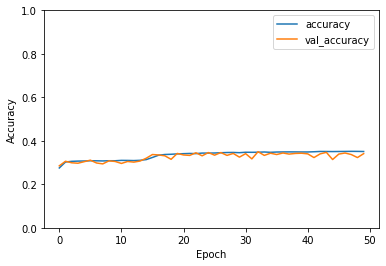

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='upper right')
